In [207]:
#Brownian motion
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from numpy import *
import matplotlib as mpl
import matplotlib.cm as cm
from sympy import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from scipy.optimize import OptimizeWarning
import seaborn as sns; import pandas as pd
plt.rcParams.update({'font.size': 14})

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-I/A)+vmin

def tothecenter(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 2

def reflect(xpos,ypos,dirangle):
    value = math.atan(ypos/xpos)*180/np.pi
    angles = np.zeros(3); checks = []
    if(xpos < 0): angles[0] = value+180
    else: angles[0] = value
    if(angles[0] < 0): angles[0] += 360
    if(angles[0] > 360): angles[0] -= 360
    for i in range(1,3): angles[i] = angles[0] + 360 * pow(-1,i)
    for i in range(3): checks.append(abs(angles[i] - dirangle))
    newangle = dirangle + 2 * (angles[checks.index(min(checks))] - dirangle) + 180
    if (newangle > 360): newangle -= 360       
    return newangle, 1, value

def reflectrand(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    angleh += np.random.uniform(-45,45)
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 1, value
    
def linear(x, m, n): return m*x+n

def disk_line_picking(s,Rin):
    return 4*s/(np.pi*Rin**2)*np.arccos(s/(2*Rin))-2*s**2/(np.pi*Rin**3)*np.sqrt(1-s**2/(4*Rin**2))
    
def calcintensity(laser,laserframe,delay):
    if delay >= 0:   #positive delay - past   - calc velocity due to sensed intensity[i-delay]
        if laserframe < delay: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[0,j,3]/amplitude)+vmin   #if i < delay
        else: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[laserframe-delay,j,3]/amplitude)+vmin
    else:            #negative delay - future
        if laserframe >= fitlength:    #extrapolate intensity value
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,j,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = vfactor*math.exp(-2*futurevalue/amplitude)+vmin
            if vvalue >= 0 and vvalue <=1: laser[laserframe,j,4] = vvalue
            else:                     # 0 < intensity < 1
                if vvalue > 1: laser[laserframe,j,4] = 1
                if vvalue < 0: laser[laserframe,j,4] = 0 
        else:     # i < delay
            if laserframe < 2: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[laserframe,j,3]/amplitude)+vmin
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,j,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                if vvalue >= 0 and vvalue <= 1: laser[laserframe,j,4] = vvalue
                else:
                    if vvalue > 1: laser[laserframe,j,4] = 1
                    if vvalue < 0: laser[laserframe,j,4] = 0  
    return laser

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def checkintersection(particle): #collision of particles
    check=True;counter=0
    while check:
        check=False;k=0;m=0
        for k in range(pnumber):
            x1=particle[i,k,0];y1=particle[i,k,1]
            for m in range(pnumber):
                if k<m:
                    x2=particle[i,m,0];y2=particle[i,m,1]
                    distance=math.sqrt((x1-x2)**2+(y1-y2)**2)
                    if distance<diameter*0.99:
                        #fig=plt.figure(1, figsize = (5,5) )
                        #ax = plt.subplot(1,1,1)
                        #ax.set_aspect('equal')
                        #istart = max(0,i-10)
                        #ax.plot(particle[istart:i,k,0]*1e6,particle[istart:i,k,1]*1e6,color='red',alpha = 0.5,zorder=2)
                        #circle2 = plt.Circle((particle[i-1,k,0]*1e6,particle[i-1,k,1]*1e6), diameter/2*1e6, alpha = 0.5,color='red',fill=False)
                        #ax.add_artist(circle2)
                        #circle2 = plt.Circle((particle[i,k,0]*1e6,particle[i,k,1]*1e6), diameter/2*1e6, linestyle='--',color='red',fill=False)
                        #ax.add_artist(circle2)                       
                        #ax.plot(particle[istart:i,m,0]*1e6,particle[istart:i,m,1]*1e6,color='black',alpha = 0.5,zorder=2)
                        #circle2 = plt.Circle((particle[i-1,m,0]*1e6,particle[i-1,m,1]*1e6), diameter/2*1e6, alpha = 0.5,color='black',fill=False)
                        #ax.add_artist(circle2)
                        #circle2 = plt.Circle((particle[i,m,0]*1e6,particle[i,m,1]*1e6), diameter/2*1e6, linestyle='--',color='black',fill=False)
                        #ax.add_artist(circle2)
                        
                        counter+=1
                        intersection=diameter-distance
                        xdist=(particle[i,k,0]-particle[i,m,0])/distance*intersection/2*(1+faster*counter)
                        ydist=(particle[i,k,1]-particle[i,m,1])/distance*intersection/2*(1+faster*counter)
                        particle[i,k,0]+=xdist
                        particle[i,m,0]-=xdist
                        particle[i,k,1]+=ydist
                        particle[i,m,1]-=ydist
                        x1=particle[i,0,0];y1=particle[i,0,1]
                        check=True
                        
                        #circle2 = plt.Circle((particle[i,k,0]*1e6,particle[i,k,1]*1e6), diameter/2*1e6,color='red',fill=False)
                        #ax.add_artist(circle2)
                        #circle2 = plt.Circle((particle[i,m,0]*1e6,particle[i,m,1]*1e6), diameter/2*1e6,color='black',fill=False)
                        #ax.add_artist(circle2)
                        #plt.xlabel('x-position [µm]')
                        #plt.ylabel('y-position [µm]')
                        #plt.show()                  
                        #print('used i = ',i,' - number = ',k,' - ',m)
        if counter>accuracy: check=False

In [245]:
name = 'test'
np.random.seed(4) 

pnumber = 5
dt = 0.05                                       #iteration time of the camera [s]
stepsexp  = 10000                                    #number of camera pictures
reorientationtimeinput = 1
noise = np.sqrt(240/(reorientationtimeinput-dt))
#noise = 10                                       #Sigma for the Gaussian noise for the angle
delay = 1                                      #Delay, negative value for anticipation
maxvelocity = 5e-6#5.25e-6                           #velocity of the particle depending on the laser power [m/s]
                                                #Fig 1c; https://www.nature.com/articles/s41467-018-06445-1.pdf
amplitude = 1
vmin = 0                                     #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533e-6                               #px to µm [µm/px]
sigma = 100*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
kB = 1.38064852e-23                              #Boltzmanns constant [J/K]
T = 273.15 + 20                                  #Room temperature [K]
eta = 2.414e-5*10**(247.8/(T-140))               #Viscosity [Pa*s]
offset = 12                                     #offset of the laser [px]
boundaryradius = pxtomum * 300                  #Radius of the boundary [px]
diameter = 2.19e-6                              #diameter of the particle [m]
fitlength = 5                                   #for negative delay, linear fit on the last N measured intensities to extrapolate intensity
diffusion = True                                #Switching diffusion on and off
value2 = 1/4     #Check inside 1/4 of boundary
driftdelay = 1 #Values for drift analyse
steps = 13
savename = str(int(noise))+' - '+str(int(delay))
sigmat = 2 * sigma * sigma

accuracy=1000
faster=0.1          #0.2 or 0.1 make it faster, 0 exact

In [246]:
shortlength = stepsexp
prefactor = np.sqrt(2*D_0*dt)                 #value for calculation of the random steps
sumhitboundary = 0
fitwave = np.linspace(-fitlength+1,1,fitlength,endpoint=False)
sigmafactor = pow(sigma,2)
vfactor=vmax-vmin
radius = diameter/2

timewave = np.linspace(0,dt*stepsexp,stepsexp,endpoint=False)  #Timewave for sub cam resolution
laser = np.zeros((shortlength,pnumber,5))              #laserposition  0 - x; 1 - y; 2 - time at which the laser is set to the new position
                                                 #               3 - Ext Int it measures; 4 - theo speed(Int laser)
particle = np.zeros((stepsexp,pnumber,8))    #cam detection  0 - x; 1 - y; 2 - time of the average particle position
                                                 #               3 - time at which the the laser is placed 
                                                 #               4 - path number
                                                 #               5 - angle; 6 - out
                                                 #               7 - Distance to center        
noisesteps = np.zeros((stepsexp,pnumber,2)); anglenoise = np.zeros((stepsexp,pnumber))
for j in range(pnumber):
    for i in range(2): noisesteps[:,j,i] = prefactor*np.random.normal(0,1,stepsexp) #Create random steps
if noise != 0: 
    for j in range(pnumber): anglenoise[:,j] = noise*np.random.normal(0,1,stepsexp)           #Create random angle noise
deltas = np.zeros(2)
rnoise = np.sqrt(np.random.uniform(0,boundaryradius**2,10*pnumber))
anglenoise2 = np.random.uniform(0,2*np.pi,10*pnumber)
anglenoisecos = np.cos(anglenoise2)
anglenoisesin = np.sin(anglenoise2)
smaller = pow(diameter,2)
count = 0
for j in range(pnumber):
    check = False
    while check == False:
        particle[0,j,0] = rnoise[count] * anglenoisecos[count]
        particle[0,j,1] = rnoise[count] * anglenoisesin[count]
        if j >= 1:
            pardist = np.zeros(j)
            for k in range(j): pardist[k] = pow(particle[0,j,0]-particle[0,k,0],2)+pow(particle[0,j,1]-particle[0,k,1],2)
            if min(pardist) >= smaller: check = True
        else: check = True
        count += 1
particle[0,:,5] = np.random.uniform(0,360,pnumber) 

In [252]:
out = np.zeros(pnumber)
startpoint = [0]; endpoint = []
start_time = time.time() 
for i in range(1,stepsexp):
    particle[i,:,2] = particle[i-1,:,2] + dt                
    particle[i,:,:2] = particle[i-1,:,:2]                              #Position equals position before
    particle[i,:,5] = particle[i-1,:,5]
    particle[i,:,7] = np.sqrt(pow(particle[i,:,0],2) + pow(particle[i,:,1],2))   #distance to the center
    for j in range(pnumber):
        if particle[i,j,7] > boundaryradius:      #particle is out
            if particle[i,j,7] > 1.1 * boundaryradius: particletest[i,j,5], out = tothecenter(particle[i,j,0],particle[i,j,1],particle[i,j,5])  #sendback to the center if something really fails
            else:
                if out == 0:   #reflect randomly at the boundary
                    particle[i,j,5], out, incidentangle = reflectrand(particle[i,j,0],particle[i,j,1],particle[i,j,5])
                    if j == 0: endpoint.append(i)
        else:  
            if particle[i-1,j,6] != 0 and j == 0: startpoint.append(i)
            out = 0
        particle[i,j,6] = out
        if out == 0: particle[i,j,5] += anglenoise[i,j]   #add noise at the angle if it is inside
        if particle[i,j,5] > 360: particle[i,j,5] -= 360
        if particle[i,j,5] < 0: particle[i,j,5] += 360
        laser[i,j,0] = particle[i,j,0]+offset*pxtomum*np.cos(particle[i,j,5]*np.pi/180)   #laser position      
        laser[i,j,1] = particle[i,j,1]+offset*pxtomum*np.sin(particle[i,j,5]*np.pi/180)
        intensity = 0
        for k in range(pnumber):
            if k != j:
                xdiff = particle[i-1,j,0]-particle[i-1,k,0]
                ydiff = particle[i-1,j,1]-particle[i-1,k,1]
                dist = pow(xdiff,2)+pow(ydiff,2)
                intensity += 2*np.exp(-dist/sigmat)
        intensity /= pnumber
        if intensity > 1: intensity = 1
        laser[i,j,3] = intensity#amplitude*math.exp(-pow(particle[i,j,7],2)/sigmafactor)        #intensity of the external field
        laser = calcintensity(laser,i,delay)     #calc laser intensity depending on the field intensity 
        if diffusion == True:
            for k in range(2): particle[i,j,k] += noisesteps[i,j,k]         #add diffusion of the particle
        for k in range(2): deltas[k] = particle[i,j,k]-laser[i,j,k]
        particle[i,j,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))      #calc particle-laser distance
        particle[i,j,4] = maxvelocity
        for k in range(2): particle[i,j,k] += particle[i,j,4]/particle[i,j,3]*deltas[k]*dt*laser[i,j,4]  #add thermophoretic movement  
        checkintersection(particle)
if particle[i,0,7] < boundaryradius: endpoint.append(i-1)   
if startpoint[-1] == shortlength: 
    del(startpoint[-1])
    del([endpoint[-1]])
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 5.11 seconds ---


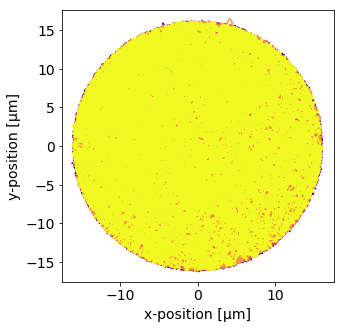

In [211]:
colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(pnumber):
    #ax.scatter(particle[0,i,0],particle[0,i,1],color='k',s = 100,zorder=3)
    circle2 = plt.Circle((particle[k,i,0]*1e6,particle[k,i,1]*1e6), diameter/2*1e6, color='grey', fill=True)
    ax.add_artist(circle2)
    ax.plot(particle[:,i,0]*1e6,particle[:,i,1]*1e6,color=colorwave[i],zorder=2)
    #ax.plot(save[:,i,0],save[:,i,1],zorder=1)
circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
value = 1.1 * boundaryradius*1e6
ax.set_xlim([-value,value])
ax.set_ylim([-value,value])
plt.show()

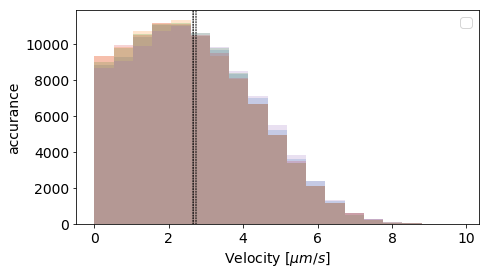

velocity particle 1 : 2.7  µm/s
velocity particle 2 : 2.63  µm/s
velocity particle 3 : 2.65  µm/s
velocity particle 4 : 2.64  µm/s
velocity particle 5 : 2.74  µm/s


In [212]:
newangle = np.zeros(stepsexp); newangle = particle[:,0,5].copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,stepsexp):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]

if noise != 0:
    check = True; i = 1
    reorwave= np.zeros((stepsexp,2))
    while check == True:
        diff = np.zeros(stepsexp-i)
        for j in range(i,stepsexp): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
        mean = np.mean(diff[:stepsexp-i])   #Calculate the standard derivation
        reorwave[i,0] = i*dt
        reorwave[i,1] = mean
        if mean/57.3 >= 1: 
            check = False
            reorlen = i
        else: i += 1 
        if i == stepsexp:
            reorlen = i
            i = 666/dt
            check = False       
    reorientationtime = i*dt 
else: reorientationtime = 666

maxlength = stepsexp
particles = np.zeros((stepsexp,pnumber,8))
particles[:,:,0] = particle[:,:,0].copy()
particles[:,:,1] = particle[:,:,1].copy()
particles[:,:,2] = particle[:,:,5]
particles[:,:,0] *= 1e6
particles[:,:,1] *= 1e6

directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,pnumber));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,pnumber))
velocity2 = np.zeros((maxlength,pnumber,2))
distancetocenter = np.zeros((maxlength,pnumber))

for j in range(pnumber):
    directionvector[:,0] = np.cos(particles[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        distancetocenter[i,j] = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        movingvector[i,0] = particles[i,j,0]-particles[i-1,j,0]
        movingvector[i,1] = particles[i,j,1]-particles[i-1,j,1]
        stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocity[i,j] = stepsize[i]/dt
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        if distancetocenter[i,j] < boundaryradius*1e6:
            velocity2[i,j,0] = velocity[i,j]
            velocity2[i,j,1] = velocitywithdiffusion[i,j]
for j in range(pnumber):
    for i in range(maxlength):
        if velocity2[i,j,0] == 0: velocity2[i,j,:]=np.nan
        
wave = velocity2[:,:,0]
binwave=np.linspace(np.amin(wave[~np.isnan(wave)]),min(np.amax(wave[~np.isnan(wave)]),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(pnumber):
    wave = velocity2[:,i,0]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
plt.savefig('Velocities'+str(savename)+'.pdf', format='pdf')
plt.show() 

for i in range(pnumber): 
    wave = velocity2[:,i,0]    
    print('velocity particle',str(i+1),':',round(np.nanmean(wave),2),' µm/s')

In [213]:
particles[:,:,7] = laser[:,:,3] 
comlocation = np.zeros((maxlength,5))
for i in range(maxlength):
    if prod(particles[i,:,0]) != 0:
        comlocation[i,0] = np.nanmean(particles[i,:,0])
        comlocation[i,1] = np.nanmean(particles[i,:,1])
for i in range(maxlength):
    if comlocation[i,0] == 0:
        pre = i-1
        check = False; checknumber = i+1
        while check == False:
            if checknumber < maxlength:
                if comlocation[checknumber,0] != 0:
                    post = checknumber
                    check = True
                else:
                    checknumber += 1
            else:
                check = True
        comlocation[i,:] = (comlocation[pre,:] + comlocation[post,:])/2
        
for i in range(maxlength):
    for j in range(pnumber):
        particles[i,j,6] = np.sqrt(pow(particles[i,j,0]-comlocation[i,0],2)+pow(particles[i,j,1]-comlocation[i,1],2))
    comlocation[i,2] = np.nanmean(particles[i,:,6])
    comlocation[i,3] = np.nanmean(particles[i,:,7])
    #comlocation[i,4] = np.mean(velocity[i,:])
    comlocation[i,4] = np.nanmean(particles[i,:,2])

meandisttocom = np.nanmean(comlocation[:,2])
meanintensity = np.nanmean(comlocation[:,3])
print('average distance to the CoM: ',meandisttocom)
print('average sensed intensity: ',meanintensity)

average distance to the CoM:  7.95537832233305
average sensed intensity:  0.38544137083729496


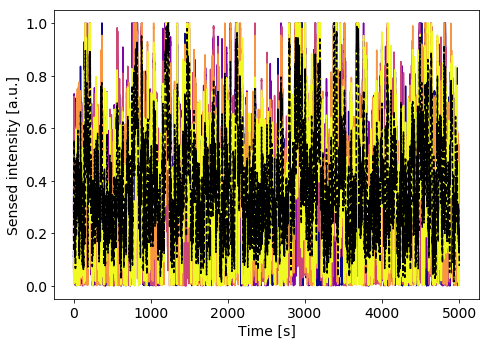

In [214]:
plotlength = maxlength#200

colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (7,5) )
for i in range(pnumber):
    plt.plot(timewave[1:plotlength],particles[1:plotlength,i,7],color=colorwave[i])
plt.plot(timewave[1:plotlength],comlocation[1:plotlength,3],'k--')
plt.xlabel('Time [s]')
#plt.ylabel('Distance to the CoM [µm]')
plt.ylabel('Sensed intensity [a.u.]')
#plt.savefig('Plot Distance to CoM'+str(filenumber)+'.pdf', format='pdf')
plt.tight_layout() 
plt.show()

In [215]:
test = np.zeros(maxlength)
for i in range(maxlength):
    count = 0
    for j in range(pnumber):
        if particles[i,j,7] > 0.2:
            count += 1
    if count >= 3:
        test[i] = 1

percentagecluster = sum(test)/maxlength
print(percentagecluster)

0.79333


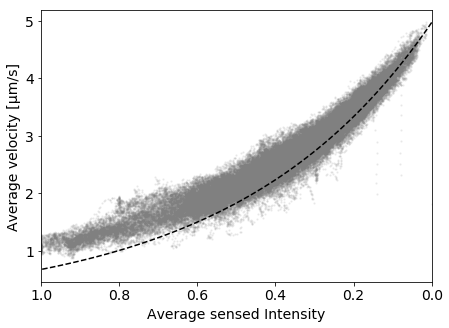

In [244]:
plotstart = 1
fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
#plt.scatter(comlocation[:,3],comlocation[:,4],s=2,c='grey',alpha=0.1)
plt.scatter(comlocation[:,3],smoothit[:,-1],s=2,c='grey',alpha=0.1)
plt.plot(vvsintensity[:,0],np.amax(smoothit[:,-1])*vvsintensity[:,1],color='k',linestyle = '--')
plt.xlabel('Average sensed Intensity')
plt.ylabel('Average velocity [µm/s]')
plt.xlim([1,0])
#plt.savefig('Velocity vs CoM-intensity'+str(filenumber)+'.pdf', format='pdf')
#plt.savefig('Velocity vs CoM-intensity'+str(filenumber)+'.png', format='png')
plt.show()

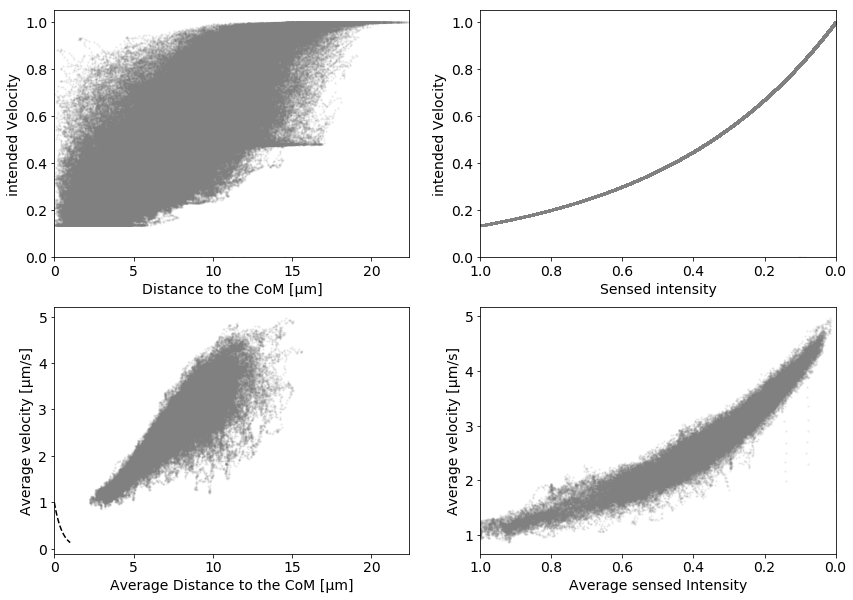

In [241]:
plotvwave = np.zeros((maxlength,pnumber))
for i in range(maxlength-1):
    plotvwave[i,:] = laser[i+1,:,4]

vvsintensity = np.zeros((100,2))
vvsintensity[:,0] = np.linspace(0,1,100)
for i in range(100):
    vvsintensity[i,1] = vfactor*math.exp(-2*vvsintensity[i,0]/amplitude)+vmin
    
plotstart = 1
fig=plt.figure(1, figsize = (14,10) )
ax = plt.subplot(2,2,1)
for i in range(pnumber):
    #plt.scatter(particles[plotstart:,i,6],laser[plotstart:,i,4],s=2,c='grey',alpha=0.1)
    plt.scatter(particles[plotstart:,i,6],plotvwave[plotstart:,i],s=2,c='grey',alpha=0.1)
plt.xlabel('Distance to the CoM [µm]')
plt.ylabel('intended Velocity')
plt.xlim([0,np.nanmax(particles[:,:,6])])
plt.ylim([0,1.05])
    
ax = plt.subplot(2,2,2)
for i in range(pnumber):
    #plt.scatter(particles[plotstart:,i,7],laser[plotstart:,i,4],s=2,c='grey',alpha=0.1)
    plt.scatter(particles[plotstart:,i,7],plotvwave[plotstart:,i],s=2,c='grey',alpha=0.1)
plt.xlabel('Sensed intensity')
plt.ylabel('intended Velocity')
plt.xlim([1,0])
plt.ylim([0,1.05])

smoothvalue = 20
smoothit = np.zeros((maxlength,pnumber+1))
for i in range(pnumber): smoothit[:,i] = smooth(velocity[:,i],smoothvalue)
for i in range(maxlength): smoothit[i,-1] = mean(smoothit[i,:-1])

ax = plt.subplot(2,2,3)
#plt.scatter(comlocation[:,2],comlocation[:,4],s=2,c='grey',alpha=0.1)
plt.scatter(comlocation[:,2],smoothit[:,-1],s=2,c='grey',alpha=0.1)
plt.xlabel('Average Distance to the CoM [µm]')
plt.ylabel('Average velocity [µm/s]')
plt.xlim([0,np.amax(particles[:,:,6])])

ax = plt.subplot(2,2,4)
#plt.scatter(comlocation[:,3],comlocation[:,4],s=2,c='grey',alpha=0.1)
plt.scatter(comlocation[:,3],smoothit[:,-1],s=2,c='grey',alpha=0.1)
plt.plot(vvsintensity[:,0],vvsintensity[:,1],color='k',linestyle = '--')
plt.xlabel('Average sensed Intensity')
plt.ylabel('Average velocity [µm/s]')
plt.xlim([1,0])
#plt.savefig('Velocity vs CoM-intensity'+str(filenumber)+'.pdf', format='pdf')
#plt.savefig('Velocity vs CoM-intensity'+str(filenumber)+'.png', format='png')
plt.show()

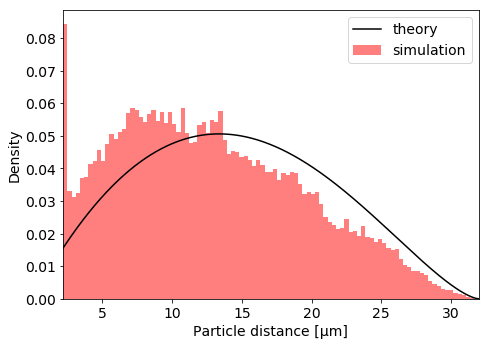

In [224]:
connections = int(pnumber*(pnumber-1)/2)
distances = np.zeros((maxlength,connections))
calclength = np.zeros(connections)
boundmum = boundaryradius*1e6# * pxtomum
trajlength = maxlength*np.ones(pnumber)
count = 0; totallength = 0
for j in range(pnumber):
    for k in range(j+1,pnumber):
        calclength[count] = int(min(trajlength[j],trajlength[k]))
        for i in range(int(calclength[count])):
            if distancetocenter[i,j] < boundmum and distancetocenter[i,k] < boundmum:
                distances[i,count] = np.sqrt(pow(particles[i,j,0]-particles[i,k,0],2)+pow(particles[i,j,1]-particles[i,k,1],2))
        totallength += calclength[count]
        count += 1
         
alldistances = np.zeros(int(totallength))
calcstart = 0; calcend = 0
for i in range(connections):
    calcend += calclength[i] 
    alldistances[int(calcstart):int(calcend)] = distances[:int(calclength[i]),i]
    calcstart += calclength[i]
for i in range(int(totallength)):
    if alldistances[i] == 0: alldistances[i] = np.nan
alldistances = alldistances[~np.isnan(alldistances)]  
meanexp = np.mean(alldistances)
meansim = 14.712

simlength = 50000
simpart = 5
connectionssim = int(simpart*(simpart-1)/2)
sim = np.zeros((simlength,simpart,2))
rnoise = np.sqrt(np.random.uniform(0,boundmum**2,2*simlength*simpart))
anglenoise = np.random.uniform(0,2*np.pi,2*simlength*simpart)
anglenoisecos = np.cos(anglenoise)
anglenoisesin = np.sin(anglenoise)
D = diameter*1e6
D_arena = 2*boundaryradius*1e6
smaller = pow(D,2)
count = 0
for i in range(simlength):
    for j in range(simpart):
        check = False
        while check == False:
            sim[i,j,0] = rnoise[count] * anglenoisecos[count]
            sim[i,j,1] = rnoise[count] * anglenoisesin[count]
            if j >= 1:
                pardist = np.zeros(j)
                for k in range(j): pardist[k] = pow(sim[i,j,0]-sim[i,k,0],2)+pow(sim[i,j,1]-sim[i,k,1],2)
                if min(pardist) >= smaller: check = True
            else: check = True
            count += 1

allsimdistances = np.zeros(int(connectionssim*simlength))
count1 = 0; count2 = 1
for i in range(connectionssim): 
    allsimdistances[i*simlength:(i+1)*simlength] = np.sqrt(pow(sim[:,count1,0]-sim[:,count2,0],2)+pow(sim[:,count1,1]-sim[:,count2,1],2))
    count2 += 1
    if count2 == simpart:
        count1 += 1
        count2 = count1 + 1
        
fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
bins = np.linspace(min(allsimdistances),2*boundmum,100)
#plt.hist(allsimdistances,bins = bins,density = 1,alpha=0.5,label='simulation')
plt.hist(alldistances,bins = bins,density = 1,color='red',alpha=0.5,label='simulation')
plt.axvline(x=2*boundmum,linewidth=0.5, color = 'k',linestyle='--')
theoradius = np.linspace(0,2*boundmum,1000)
plt.plot(theoradius,disk_line_picking(theoradius,boundmum),color='k',label='theory')
plt.xlabel('Particle distance [µm]')
plt.ylabel('Density')
plt.xlim([D,D_arena])
plt.legend()
#plt.savefig('Particle Distance distribution'+str(filenumber)+'.pdf', format='pdf')
plt.tight_layout() 
plt.show()

In [221]:
for k in range(pnumber):
    value = plotvwave[:,k]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength-1):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i,k]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i,k]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i,k]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i,k]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    for i in range(maxlength-1):
        for j in range(steps2):
            if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan

    maxvelocity = speedhisto[-1,1]
    print('maxvelocity = ',round(maxvelocity,2))

maxvelocity =  4.65
maxvelocity =  4.64
maxvelocity =  4.63
maxvelocity =  4.64
maxvelocity =  4.65


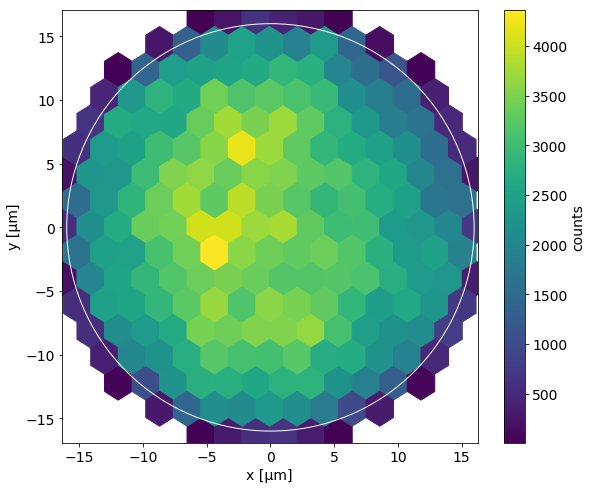

In [222]:
x = particles[:,:,0]
y = particles[:,:,1]
factor = 1.1
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
gridsizevalue = 15
#fig, axs = plt.subplots(ncols=1, figsize=(8.5,7), sharex='all')
#fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)

fig=plt.figure(1, figsize = (8.5,7) ) 
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = plt.subplot(1,1,1)
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
#ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.axis('equal')
plt.tight_layout() 
#plt.savefig('Path of the particle colored'+str(filenumber)+'.pdf', format='pdf')
#plt.savefig('Path of the particle colored'+str(filenumber)+'.svg', format='svg')
plt.show()

In [223]:
boundaryradius

1.599e-05

In [ ]:
k = 50
R = diameter/2
boundmum = boundaryradius * 1e6
fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(pnumber):
    #plt.scatter(0,0,color='grey',s=202778)
    plt.scatter(particles[k,i,0],particles[k,i,1],color='grey',s=(R*1e6)**2)
    circle2 = plt.Circle((particles[k,i,0],particles[k,i,1]), R*1e6, color='grey', fill=True)
    ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
circle2 = plt.Circle((0, 0), boundmum, color='k', fill=False)
ax.add_artist(circle2)
factor = 1.1
ax.set_xlim([-factor*boundmum,factor*boundmum])
ax.set_ylim([-factor*boundmum,factor*boundmum])
plt.show()